In [21]:
# Block 1: 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 机器学习核心库
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier

# 忽略一些版本兼容性的警告，保持输出整洁
warnings.filterwarnings('ignore')

# 绘图设置
sns.set(style="whitegrid", palette="muted")
plt.rcParams['axes.unicode_minus'] = False 

print("Block 1: 库导入完成！")

Block 1: 库导入完成！


In [22]:
# Block 2: 数据加载与特征工程 (Feature Engineering)
import os

# 👇 请确认你的文件路径
file_path = r"./data/WA_Fn-UseC_-HR-Employee-Attrition.csv" 

if not os.path.exists(file_path):
    print(f"错误：找不到文件，请检查路径: {file_path}")
else:
    df = pd.read_csv(file_path)
    print(f"数据加载成功，原始形状: {df.shape}")

    # 1. 平均每份工作的时间 (AvgTenure): 识别频繁跳槽者
    # 分母加1是为了防止除以0
    df['AvgTenure'] = df['TotalWorkingYears'] / (df['NumCompaniesWorked'] + 1)

    # 2. 职业/年龄比 (CareerAgeRatio): 衡量入行早晚或职业密度
    df['CareerAgeRatio'] = df['TotalWorkingYears'] / df['Age']

    # 3. 忠诚度 (TenureRatio): 在当前公司的年限占总工龄的比例
    df['TenureRatio'] = df['YearsAtCompany'] / (df['TotalWorkingYears'] + 1)

    # 4. 晋升停滞感 (PromotionStagnation): 在当前岗位待的时间 / 上次晋升到现在的时间
    # 如果数值很大，说明很久没晋升了，容易离职
    df['PromotionStagnation'] = df['YearsInCurrentRole'] / (df['YearsSinceLastPromotion'] + 1)

    # 5. 年龄薪资比 (IncomePerAge): 衡量薪资在同龄人中的竞争力
    df['IncomePerAge'] = df['MonthlyIncome'] / df['Age']

    print("特征工程完成！")

数据加载成功，原始形状: (1470, 35)
特征工程完成！


In [23]:
# Block 3: 数据清洗与切分
# 1. 删除无用特征
drop_cols = ['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber']
df.drop(drop_cols, axis=1, inplace=True)

# 2. 标签编码 (Yes -> 1, No -> 0)
df['Attrition'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3. One-Hot 编码 (处理部门、职位等文本特征)
df = pd.get_dummies(df, drop_first=True)

# 4. 划分 X 和 y
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# 5. 切分训练集与测试集 (Stratify保证离职率分布一致)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"训练集维度: {X_train.shape}")
print(f"测试集维度: {X_test.shape}")
print("Block 3: 数据准备就绪。")

训练集维度: (1176, 49)
测试集维度: (294, 49)
Block 3: 数据准备就绪。


In [24]:
# Block 4: 配置模型与超参数搜索空间 (GPU 加速版)
import torch # 用于检查 CUDA

# 检查 GPU 是否可用
if torch.cuda.is_available():
    print(f"✅ 检测到 GPU: {torch.cuda.get_device_name(0)}")
    device_config = 'cuda'
else:
    print("⚠️ 未检测到 GPU，将回退到 CPU 模式。")
    device_config = 'cpu'

# 计算基础的不平衡比例
base_ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

# 定义参数分布
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 8], # GPU 跑得快，可以尝试更深的树
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'scale_pos_weight': [base_ratio, base_ratio * 0.8]
}

# 初始化 XGBoost (启用 GPU)
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    # --- GPU 核心配置 ---
    device=device_config,      # 指定使用 cuda (NVIDIA GPU)
    tree_method='hist',        # 配合 device='cuda' 使用直方图算法（极快）
    # ------------------
    random_state=42,
    n_jobs=1  # ⚠️ 重要：使用 GPU 时，请将 CPU 线程设为 1，防止冲突
)

print(f"🚀 开始随机搜索 (Randomized Search) - 运行设备: {device_config.upper()}...")

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,          
    scoring='f1',       
    cv=StratifiedKFold(n_splits=5), 
    verbose=1,
    random_state=42,
    n_jobs=1  # 搜索本身的调度也设为 1，让 GPU 专心跑模型
)

print("✅ Block 4: GPU 模式配置完成。")

✅ 检测到 GPU: NVIDIA GeForce RTX 4060 Laptop GPU
🚀 开始随机搜索 (Randomized Search) - 运行设备: CUDA...
✅ Block 4: GPU 模式配置完成。


In [25]:
# Block 5: 开始训练 (Training)
print("开始随机搜索优化... 请稍候...")

search.fit(X_train, y_train)

best_model = search.best_estimator_
print("\n" + "="*40)
print(f"✅ 最优参数: {search.best_params_}")
print(f"✅ 最佳验证集 F1 Score: {search.best_score_:.4f}")
print("="*40)

开始随机搜索优化... 请稍候...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ 最优参数: {'subsample': 0.6, 'scale_pos_weight': 4.151578947368421, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.6}
✅ 最佳验证集 F1 Score: 0.5296


In [26]:
# Block 6: 微调决策阈值

# 1. 拿到预测概率
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 2. 遍历阈值寻找最佳点
thresholds = np.arange(0.2, 0.8, 0.01)
f1_scores = []

for t in thresholds:
    pred_temp = (y_pred_proba > t).astype(int)
    f1_scores.append(f1_score(y_test, pred_temp))

# 3. 获取最佳阈值
best_thresh_index = np.argmax(f1_scores)
best_thresh = thresholds[best_thresh_index]
best_f1_val = f1_scores[best_thresh_index]

print(f"最佳截断阈值: {best_thresh:.2f}")
print(f"对应的 F1 Score: {best_f1_val:.4f}")

最佳截断阈值: 0.37
对应的 F1 Score: 0.4861



--- Final Classification Report ---
              precision    recall  f1-score   support

           0       0.94      0.75      0.83       247
           1       0.36      0.74      0.49        47

    accuracy                           0.75       294
   macro avg       0.65      0.75      0.66       294
weighted avg       0.85      0.75      0.78       294



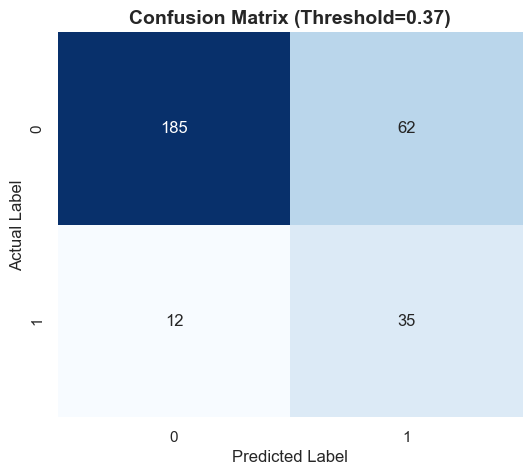

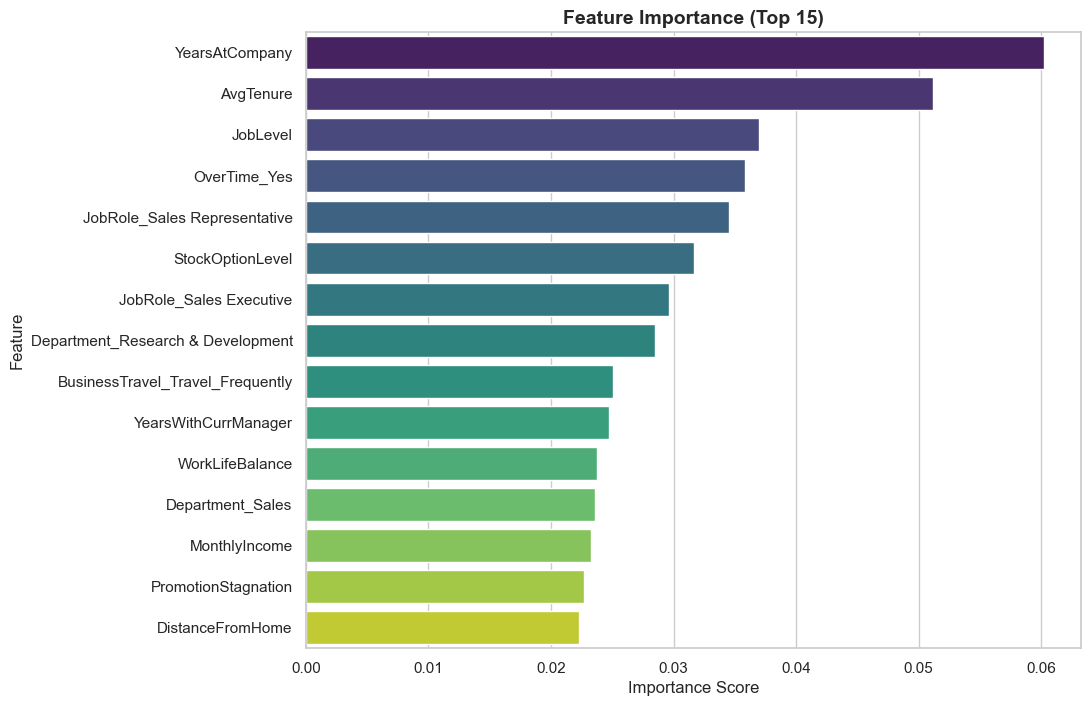

In [27]:
# Block 7: 最终可视化

# 使用最佳阈值生成最终预测结果
y_pred_final = (y_pred_proba > best_thresh).astype(int)

# 1. 打印详细报告
print("\n--- Final Classification Report ---")
print(classification_report(y_test, y_pred_final))

# 2. 绘制混淆矩阵
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Threshold={best_thresh:.2f})', fontsize=14, fontweight='bold')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 3. 绘制特征重要性 (验证新特征是否有效)
feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': best_model.feature_importances_})
feat_imp = feat_imp.sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(y='Feature', x='Importance', data=feat_imp, palette='viridis')
plt.title("Feature Importance (Top 15)", fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.show()

正在生成 SHAP 摘要图...


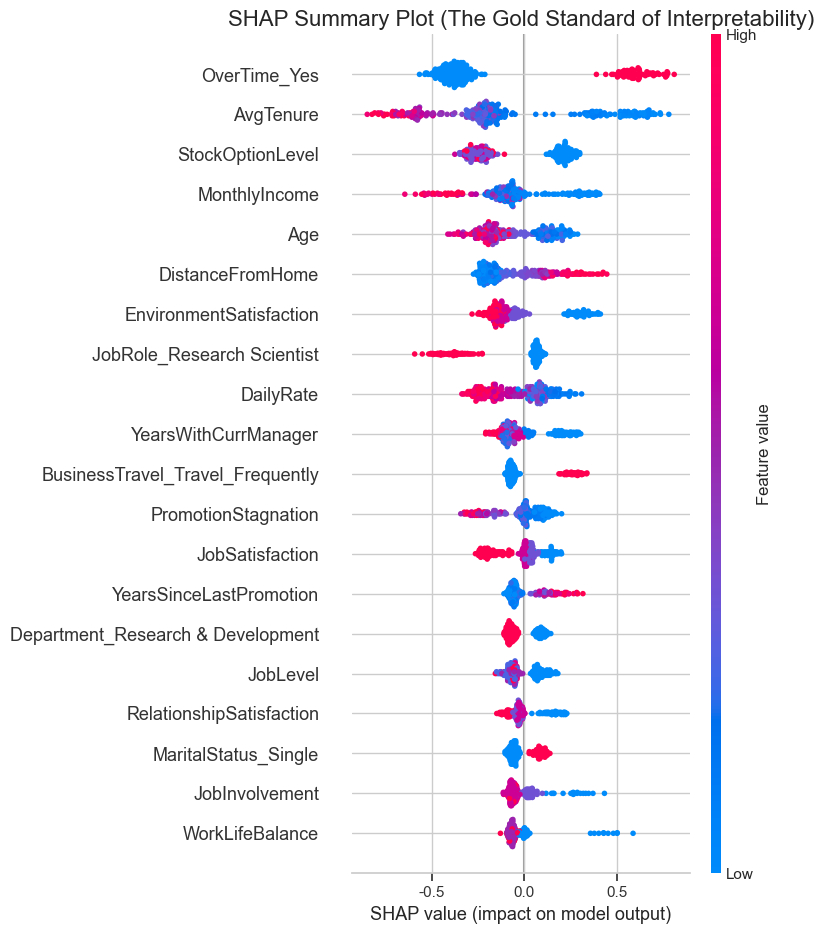

In [28]:
# Block 9: SHAP 深度可解释性分析
import shap

# 1. 初始化解释器
explainer = shap.TreeExplainer(best_model) # 使用之前的最佳 XGBoost 模型
shap_values = explainer.shap_values(X_test)

# 2. 绘制 Summary Plot (最经典的一张图)
print("正在生成 SHAP 摘要图...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary Plot (The Gold Standard of Interpretability)", fontsize=16)
plt.tight_layout()
plt.show()

# 3. 怎么看这张图？(写进报告)
# - 每一行是一个特征
# - 每一个点是一个样本（员工）
# - 红色代表该特征数值高，蓝色代表低
# - 点在右边代表“增加了离职概率”，在左边代表“降低了离职概率”